<a href="https://colab.research.google.com/github/SimonGeb/Deep-Learning/blob/main/Noisy_images_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/TU Delft/Master/Deep Learning/Reproducability Project

/content/drive/.shortcut-targets-by-id/1DuKt88mVXJTHanb5KcuJgrsmJcTSkPkb/Reproducability Project


In [ ]:
pip install --upgrade tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# uniform content loss + adaptive threshold + per_class_input + recursive G
# improvement upon cqf37
from __future__ import division
import os, scipy.io
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tf_slim as slim
import numpy as np
import rawpy
import glob
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:

DEBUG = 0
if DEBUG == 1:
    save_freq = 2
    test_ids = test_ids[0:5]


def lrelu(x):
    return tf.maximum(x * 0.2, x)

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)

def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a numpy array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The numpy array must be either 2 dimensional or 3 dimensional.
    """
    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

def upsample_and_concat(x1, x2, output_channels, in_channels):
    pool_size = 2
    deconv_filter = tf.Variable(tf.truncated_normal([pool_size, pool_size, output_channels, in_channels], stddev=0.02))
    deconv = tf.nn.conv2d_transpose(x1, deconv_filter, tf.shape(x2), strides=[1, pool_size, pool_size, 1])

    deconv_output = tf.concat([deconv, x2], 3)
    deconv_output.set_shape([None, None, None, output_channels * 2])

    return deconv_output

def network(input):
    conv1 = slim.conv2d(input, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_1')
    conv1 = slim.conv2d(conv1, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv1_2')
    pool1 = slim.max_pool2d(conv1, [2, 2], padding='SAME')

    conv2 = slim.conv2d(pool1, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_1')
    conv2 = slim.conv2d(conv2, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv2_2')
    pool2 = slim.max_pool2d(conv2, [2, 2], padding='SAME')

    conv3 = slim.conv2d(pool2, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_1')
    conv3 = slim.conv2d(conv3, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv3_2')
    pool3 = slim.max_pool2d(conv3, [2, 2], padding='SAME')

    conv4 = slim.conv2d(pool3, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_1')
    conv4 = slim.conv2d(conv4, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv4_2')
    pool4 = slim.max_pool2d(conv4, [2, 2], padding='SAME')

    conv5 = slim.conv2d(pool4, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_1')
    conv5 = slim.conv2d(conv5, 512, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv5_2')

    up6 = upsample_and_concat(conv5, conv4, 256, 512)
    conv6 = slim.conv2d(up6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_1')
    conv6 = slim.conv2d(conv6, 256, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv6_2')

    up7 = upsample_and_concat(conv6, conv3, 128, 256)
    conv7 = slim.conv2d(up7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_1')
    conv7 = slim.conv2d(conv7, 128, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv7_2')

    up8 = upsample_and_concat(conv7, conv2, 64, 128)
    conv8 = slim.conv2d(up8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_1')
    conv8 = slim.conv2d(conv8, 64, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv8_2')

    up9 = upsample_and_concat(conv8, conv1, 32, 64)
    conv9 = slim.conv2d(up9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_1')
    conv9 = slim.conv2d(conv9, 32, [3, 3], rate=1, activation_fn=lrelu, scope='g_conv9_2')

    conv10 = slim.conv2d(conv9, 12, [1, 1], rate=1, activation_fn=None, scope='g_conv10')
    out = tf.depth_to_space(conv10, 2)
    return out

def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    black = raw.black_level_per_channel
    print(black)
    print(raw.raw_pattern)
    im = np.maximum((im - np.mean(black)), 0) / ((4095) - np.mean(black))  # subtract the black level
  
    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
  
    H = img_shape[0]
    W = img_shape[1]

    R = im[0:H:2, 0:W:2, :] # Every alternating value starting from position (0,0) 
    G = im[0:H:2, 1:W:2, :] # Every alternating value starting from position (0,1) 
    B = im[1:H:2, 1:W:2, :] # Every alternating value starting from position (1,1) 
    G_e = im[1:H:2, 0:W:2, :] # Every alternating value starting from position (1,0)  
    out = np.concatenate((R, G, B, G_e), axis=2) # Always in R-G-B-G format
    
    return out



In [ ]:
def saveImg(img, dir, id):
  plt.rcParams['savefig.dpi'] = 600
  plt.imshow(img)
  plt.axis('off')
  plt.savefig(dir + id, bbox_inches='tight')
  plt.clf()


def pack_raw_gaussianNoise(raw, σ):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)

    noise = np.rint(np.random.normal(scale=σ, size=np.shape(out)))
    out = np.clip(out + noise, 0, 1)

    return out


def pack_raw_saltPepper(img, rate):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    
    s = np.shape(out)
    pix = int(len(out.flatten()) * rate / 200)                                   #divide by 200 to get percentage of pixels
    for i in range(pix):
      out[np.random.randint(0, s[0]), np.random.randint(0, s[1]), :] = 1
      out[np.random.randint(0, s[0]), np.random.randint(0, s[1]), :] = 0

    return out

In [ ]:
input_dir = './dataset/Sony/short/'
gt_dir = './dataset/Sony/long/'
checkpoint_dir = './checkpoint/Sony/'
clean_dir = './result_Clean/'
noise_dir = './result_Noise_In/'
result_dir = './result_Noise_Out/'

In [ ]:
sess = tf.Session()
in_image = tf.placeholder(tf.float32, [None, None, None, 4])
gt_image = tf.placeholder(tf.float32, [None, None, None, 3])
out_image = network(in_image)

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
# get test IDs
test_fns  = glob.glob(input_dir + '/1*_00_0.04s.ARW')
test_fns  = [test_fns[i] for i in [22, 12, 15, 19, 25]]                             #select specific images

load_ids  = [os.path.basename(test_fn) for test_fn in test_fns]
save_ids = [i[:-13] for i in load_ids]

gt_fns = [glob.glob(gt_dir + '%d_00_10s.ARW' %(int(i))) for i in save_ids]
assert(len(gt_fns) == len(load_ids))                                            #verify all the images are short 0.04s - long 10s

print(load_ids)
#print(save_ids)
#print(gt_fns)

testing  = False
save     = True

####
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
if ckpt:
    print('loaded ' + ckpt.model_checkpoint_path)
    saver.restore(sess, ckpt.model_checkpoint_path)

['10199_00_0.04s.ARW', '10055_00_0.04s.ARW', '10178_00_0.04s.ARW', '10192_00_0.04s.ARW', '10217_00_0.04s.ARW']
loaded ./checkpoint/Sony/model.ckpt


In [ ]:
i = 0 
for load_id in load_ids:
  load_id = load_ids[4]
  in_file = glob.glob(input_dir + load_id)[0]

  raw = rawpy.imread(in_file)  

  ratio = 250 

  std  = np.array([0, 0.05, 0.1, 0.3, 0.6, 0.9, 1.5])                           #standard deviation for gaussian
  rate = np.array([0, 0.1,  0.5, 1,   5,   10,  25])                            #pixels to adjust in % for salt & pepper noise
  noisetype = 'salt'                                                           # adjust here: gauss or salt

  for σ in rate:                                                                 # adjust here: std or rate
    input_full = np.expand_dims(pack_raw_saltPepper(raw, σ), axis=0) * ratio
    input_full = np.minimum(input_full, 1.0)

    noise = input_full[0, :, :, :-1]

    if (testing): 
      output = sess.run(out_image, feed_dict={in_image: input_full})
      output = np.minimum(np.maximum(output, 0), 1)

      output = output[0, :, :, :]
    
      toimage(output * 255, high=255, low=0, cmin=0, cmax=255).save(
          result_dir + '%d%s_%g.png' % (int(save_ids[i]), noisetype, σ))
    #End of testing loop

    if (save):
      toimage(noise * 255, high=255, low=0, cmin=0, cmax=255).save(
          noise_dir + '%d%s_%g.jpeg' % (int(save_ids[i]), noisetype, σ))    
    #End of saving loop

    print("processed image {} {}".format(int(save_ids[i]), σ))
  #End of standard deviation loop
  break
  i += 1

<ipython-input-7-6f8a73aabd2a>:162: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  strdata = bytedata.tostring()


processed image 10199 0.0
processed image 10199 0.1
processed image 10199 0.5
processed image 10199 1.0
processed image 10199 5.0
processed image 10199 10.0
processed image 10199 25.0


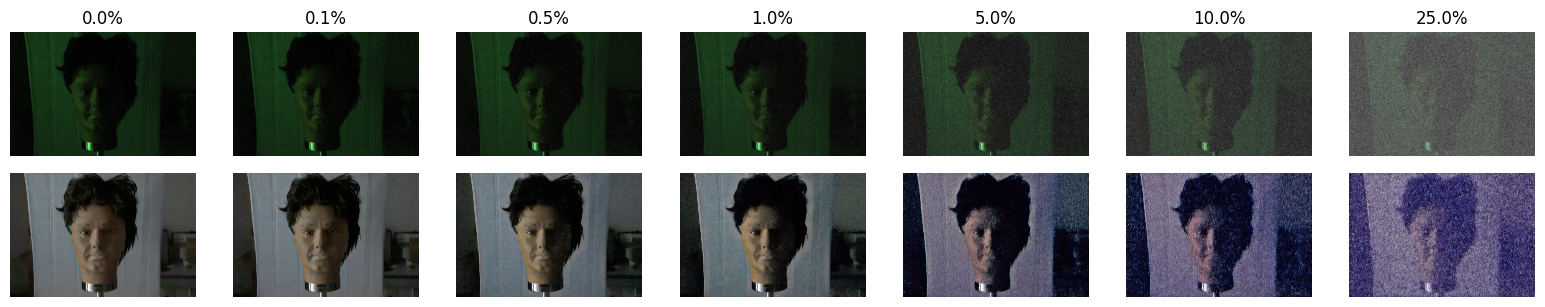

In [ ]:
fig, axs = plt.subplots(2, 7)

rate = np.array([0, 0.1,  0.5, 1,   5,   10,  25])

i = 0
noisetype = 'salt'
loop      = rate
pic_id    = 3

for val in loop:

  im = Image.open(noise_dir + '%d%s_%g.jpeg' % (int(save_ids[pic_id]), noisetype, val))
  axs[0,i].imshow(im)
  axs[0,i].axis('off')
  axs[0,i].set_title(str(val)+ '%')


  im = Image.open(result_dir + '%d%s_%g.png' % (int(save_ids[pic_id]), noisetype, val))
  axs[1,i].imshow(im)
  axs[1,i].axis('off')

  i += 1
  #break




#set figure size
fig.tight_layout()
fig.set_size_inches(16, 4)
plt.rcParams['savefig.dpi'] = 1000
plt.savefig(result_dir + '%d%s.png'%(int(save_ids[pic_id]), noisetype))
